# Eigengene SVA Analysis

**Created**: 13 December 2021

## Environment

In [1]:
rm(list=ls())

In [2]:
library(tidyverse)
library(data.table)
library(parallel)

setwd("~/eQTL_pQTL_Characterization/")

source("04_Expression/scripts/utils/ggplot_theme.R")

── Attaching packages ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose




## Load Data

In [3]:
geno <- fread("~/gains_team282/Genotyping/All_genotyping_merged_filtered_b38_refiltered_rsID.bim")
colnames(geno) <- c("chr", "snp", "cM", "pos", "minor", "major")

In [4]:
eigengenes <- read.csv("~/gains_team282/nikhil/expression/gene_expression/eigengenes.csv", row.names=1)

## Manhattan Plots

The genome-wide significance threshold is calculated using a Bonferroni correction of a significance threshold of 0.05. We performed tests for 66 individual eigengenes for 70300 SNPs. This threshold is slightly larger than 1e-8, so I will use that cutoff instead.

Under the null distribution, $t=\frac{\hat{\beta}}{SE}$ follows a T distribution with degrees of freedom close to $n$. The genomic inflation score measures the deviation from this expected distribution while accounting for outliers expected from a few true positives. The score is

$$\lambda = \frac{\text{median}(t^2)}{\text{median}(\chi_1^2)}$$

where $t$ is the T-statistic for $\beta$. Here, we assume that the T Distribution can be approximated as a standard normal distribution since $n$ is relatively large.

In [24]:
me.assocs <- do.call(rbind, lapply(list.files("~/gains_team282/nikhil/expression/eigengene_sva/initial_pass/", pattern="*.tsv"), function(file) {
    file.full = paste0("~/gains_team282/nikhil/expression/eigengene_sva/initial_pass/", file)
    me.assoc = fread(file.full, sep="\t", fill=TRUE) %>%
        as.data.frame() %>%
        dplyr::mutate(me = gsub("\\.tsv", "", file)) %>%
        dplyr::select(snp=1, beta=2, se=3, t=4, p=5, me)
}))

In [32]:
lambdas <- me.assocs %>%
    dplyr::group_by(me) %>%
    dplyr::summarize(lambda = median(qchisq(1 - p, 1)) / qchisq(0.5, 1))

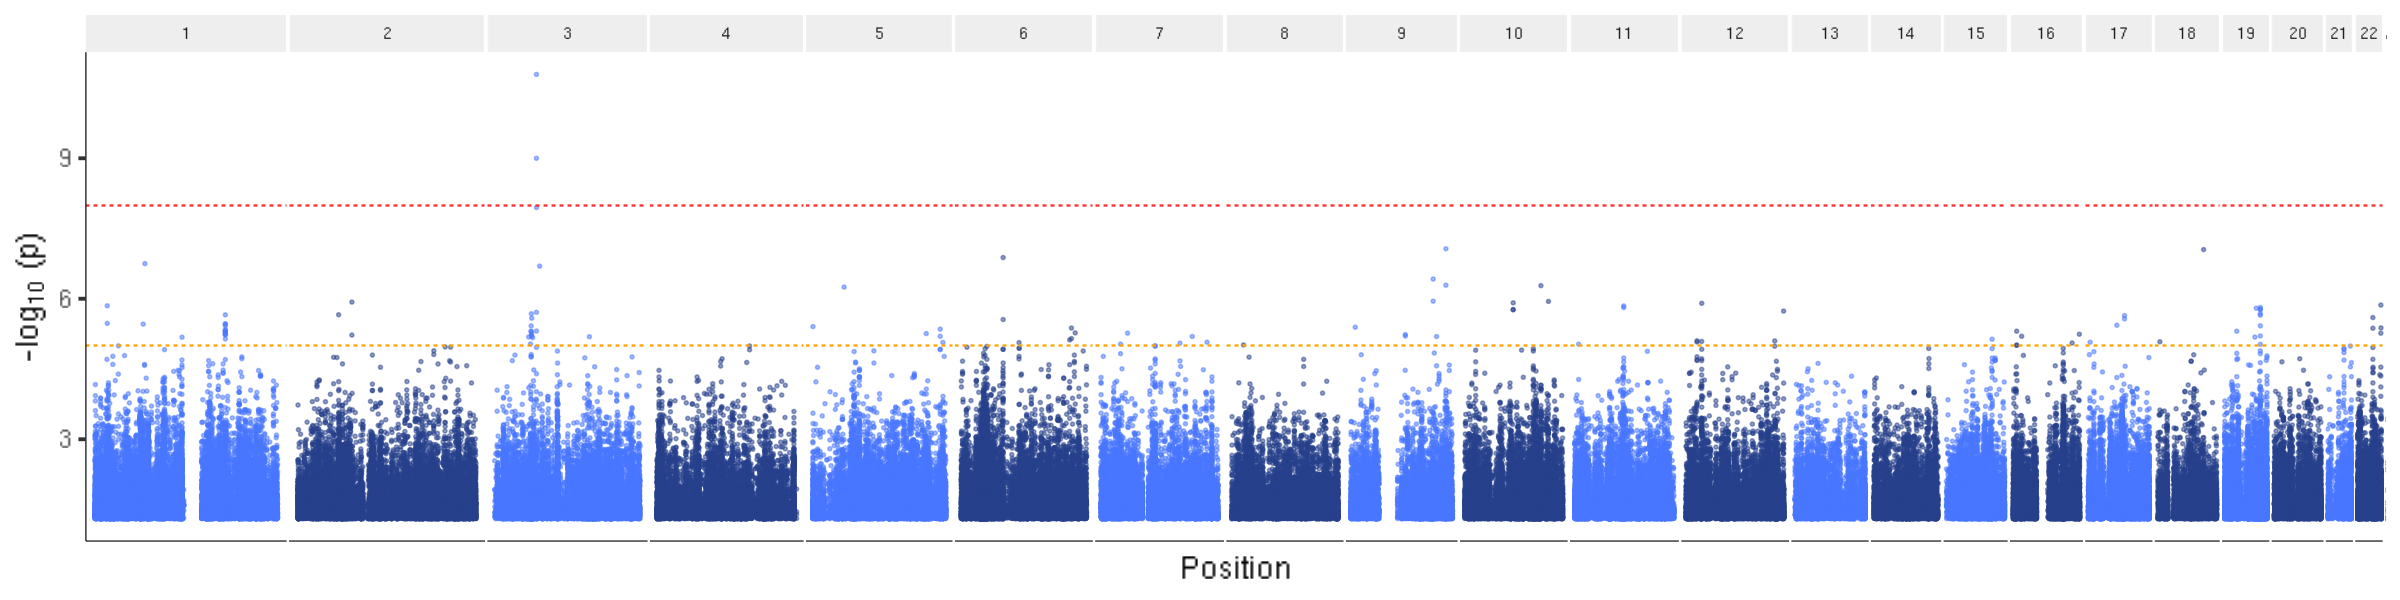

In [51]:
options(repr.plot.width=20, repr.plot.height=5)

me.assocs %>%
    dplyr::filter(p < 0.05) %>%
    merge(., geno, by="snp") %>%
    dplyr::mutate(chr=factor(chr, levels=1:22)) %>%
    dplyr::mutate(chr.type=ifelse(as.numeric(chr) %% 2 == 0, "Even", "Odd")) %>%
    dplyr::mutate(Log.10.p = -log10(p)) %>%
    ggplot() +
    geom_point(aes(x=pos, y=Log.10.p, color=chr.type), size=I(0.5), alpha=0.5) +
    geom_hline(yintercept=-log10(1e-5), lty=2, color="orange") +
    geom_hline(yintercept=-log10(1e-8), lty=2, color="firebrick1") +
    scale_color_manual(values=c("Even" = "royalblue4", "Odd" = "royalblue1")) +
    facet_grid(~chr, scale="free_x", space="free_x") +
    guides(color="none") +
    xlab("Position") + ylab(expression('-log'[10]~'(p)')) +
    ggplot_theme +
    theme(
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        panel.spacing=unit(0.1, "lines"),
        strip.text=element_text(size=9)
    )

ggsave("04_Expression/results/manhattan_initial_pass.png", width=20, height=5, dpi=600)

## P-Value Q-Q Plots

Under the null hypothesis, we expect p-values for multiple tests to have a uniform distribution. If there is inflation in the data (that is, variants are associated with the quantitative variable due to population stratification), this p-value distribution will be skewed towards significance. This is quantified with the genomic inflation factor ($\lambda$). We can also plot the Q-Q plot for the p-values to check for deviation from the expected distribution. The p-values for true significant hits (close to 0) should deviate from the distribution, but the rest (indicating true negatives) should follow the distribution faithfully.

In [39]:
file <- "ME_47.tsv"
file.full <- paste0("~/gains_team282/nikhil/expression/eigengene_sva/initial_pass/", file)

me.assoc <- fread(file.full)
colnames(me.assoc) <- c("snp", "beta", "se", "t", "p")

The genomic inflation factor for this eigengene.

In [40]:
lambdas %>%
    dplyr::filter(me == gsub("\\.tsv", "", file))

me,lambda
<chr>,<dbl>
ME_47,1.029637


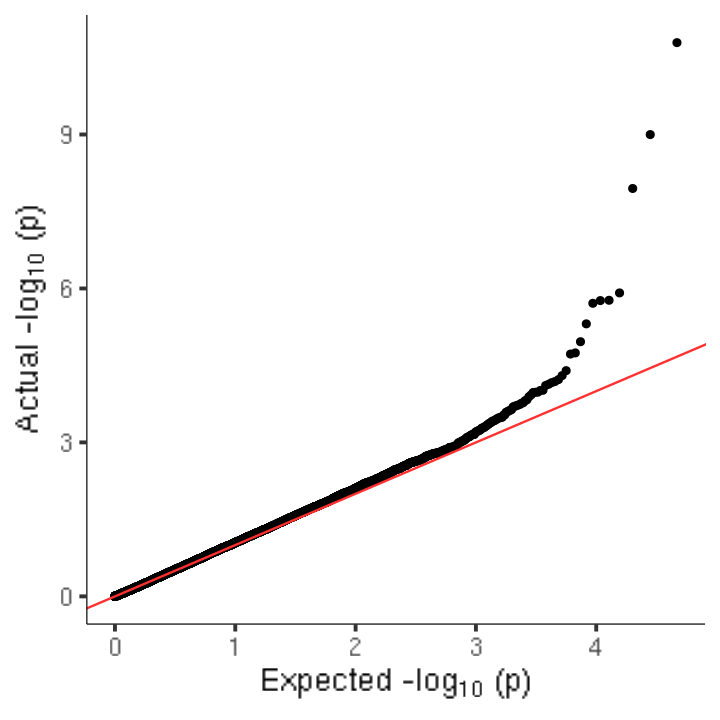

In [43]:
options(repr.plot.width=6, repr.plot.height=6)

exp.p.assoc <- me.assoc %>%
    as.data.frame() %>%
    dplyr::mutate(expected.p=(rank(p, ties.method="first") + 0.5) / (length(p) + 1)) %>%
    dplyr::mutate(Log.10.P=-log10(p)) %>%
    dplyr::mutate(Expected.Log.10.P=-log10(expected.p))

dplyr::bind_rows(
    exp.p.assoc %>% dplyr::mutate(Expected.Log.10.P < 5) %>% dplyr::sample_frac(0.001),
    exp.p.assoc %>% dplyr::mutate(Expected.Log.10.P >= 5)
) %>%
    ggplot() +
    geom_point(aes(x=Expected.Log.10.P, y=Log.10.P)) +
    geom_abline(slope=1, intercept=0, color="firebrick1") +
    xlab(expression("Expected -log"[10]~"(p)")) +
    ylab(expression("Actual -log"[10]~"(p)")) +
    ggplot_theme

In [ ]:
me.set <- gsub(".png", "", list.files("04_Expression/results/manhattan_cell_proportions/"))
me.set <- setdiff(me.set, "ME_95")
me.assoc.loci <- rbindlist(mclapply(me.set, function(me) {
    me.assoc = fread(paste0("~/gains_team282/nikhil/expression/eigengene_sva/cell_proportions/", me, ".tsv"), sep="\t", fill=TRUE)
    colnames(me.assoc) <- c("snp", "beta", "se", "t", "p")
    me.assoc = me.assoc[p < 1e-5, ]
    me.assoc[, ME := me]
    return(me.assoc)
}))

In [ ]:
merge(me.assoc.loci, geno, by="snp") %>%
    dplyr::arrange(chr, ME, pos)

snp,beta,se,t,p,ME,chr,cM,pos,minor,major
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>,<int>,<chr>,<chr>
rs79430388,0.01608502,0.003577264,4.496458,9.653380e-06,ME_11,1,0,188186712,A,G
rs2229833,0.02084563,0.004177115,4.990438,7.346203e-07,ME_25,1,0,1291271,C,G
rs146086079,0.02011660,0.004130583,4.870159,1.334269e-06,ME_25,1,0,1294650,A,G
rs116119245,0.01988110,0.004191443,4.743259,2.474191e-06,ME_25,1,0,1299174,C,A
rs115765949,0.02011660,0.004130583,4.870159,1.334269e-06,ME_25,1,0,1301476,T,C
rs115928552,0.01988110,0.004191443,4.743259,2.474191e-06,ME_25,1,0,1304328,G,C
rs77293210,0.01982193,0.004196037,4.723964,2.716134e-06,ME_25,1,0,1306366,C,T
rs307346,0.01420651,0.003182936,4.463334,9.150929e-06,ME_25,1,0,1325353,A,C
rs307354,0.01418088,0.003178633,4.461314,9.232814e-06,ME_25,1,0,1329159,G,C
